## Introducción a las convoluciones.

En este capítulo vamos a necesitar los siguientes elementos que aquí importamos

In [2]:
import random
import numpy as np
from PIL import Image
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Normalize
from data_generation.image_classification import generate_dataset
from helpers import index_splitter, make_balanced_sampler # construidos en capitulo 4
from stepbystep.v1 import StepByStep

## Convoluciones.

```{index} Convoluciones
```

En el último capítulo anterior, hablamos de los píxeles como características o features: consideramos cada píxel como una característica individual e independiente, por lo que perdiamos información al aplanar la imagen. También hablamos
de los pesos como píxeles, y de cómo podíamos interpretar los pesos utilizados por una neurona como una imagen o, más concretamente, como un filtro.

Ahora, es el momento de dar un paso más y aprender sobre las convoluciones. Una convolución es "una operación matemática sobre dos funciones (f y g) que produce una tercera función (f * g) que expresa cómo la forma de una es modificada por la otra". En el procesamiento de  imágenes, una matriz de convolución también se denomina kernel o filtro.

Las operaciones típicas de procesamiento de imágenes, como el desenfoque, la nitidez, la detección de bordes, etc., se llevan a cabo mediante una convolución entre un núcleo y una imagen.

## Filtro / Kernel

En pocas palabras, se define un filtro (o núcleo, pero aquí nos quedamos con la expresión *filtro*), y se aplica este filtro a una imagen (es decir, se convoluciona una imagen). Normalmente, los filtros son pequeñas matrices cuadradas. La convolución en sí se realiza aplicando el filtro a la imagen repetidamente. Intentemos un ejemplo concreto para que quede más claro.

Para explicar mejor todo esto, usamos una imagen de un solo canal, y el filtro más aburrido de todos, el *filtro de identidad*.

![filtro de convolución](figuras/Convolucion1.PNG)

```{index} campo receptivo
```

¿Ve la región gris en la esquina superior izquierda de la imagen, que tiene el mismo tamaño que el filtro? Esa es la región a la que se aplica el filtro y se llama *campo receptivo*, haciendo una analogía con el funcionamiento de la visión humana.
a la forma en que funciona la visión humana.

En la pagina web <a href="https://setosa.io/ev/image-kernels/" target="_blan">  https://setosa.io/ev/image-kernels/ </a> puedes ver de forma real cómo se transforma una imagen después de aplicar diversos kernels.

Además, fíjate en las formas que hay debajo de las imágenes: las formas siguen la convención de formas NCHW utilizada por PyTorch. Hay una imagen, un canal, de seis por seis píxeles. Hay un filtro de un canal, de tres por tres píxeles.

Por último, el asterisco representa la operación de convolución entre los dos (la imagen y el filtro).

Vamos a crear matrices Numpy para seguir las operaciones, después de todo, de esta manera es más fácil de entender en el código.

In [3]:
single = np.array(
[[[[5, 0, 8, 7, 8, 1],
[1, 9, 5, 0, 7, 7],
[6, 0, 2, 4, 6, 6],
[9, 7, 6, 6, 8, 4],
[8, 3, 8, 5, 1, 3],
[7, 2, 7, 0, 1, 0]]]]
)

In [3]:
single.shape

(1, 1, 6, 6)

In [5]:
identity = np.array(
[[[[0, 0, 0],
[0, 1, 0],
[0, 0, 0]]]]
)
identity.shape

(1, 1, 3, 3)

En realidad es bastante simple lo que se hace en la convolución: realiza una multiplicación entre los dos (región y filtro) por elementos (es decir número a número) y después como resultado final suma todo.

Vamos a comprobarlo, ampliando la región región seleccionada:

![operación convolución](figuras/convolucion2.PNG)

Con código lo haremos de la siguiente manera

In [5]:
# selección de los elementos matriz inicial
region = single[:, :, 0:3, 0:3]
#Multiplicamos elemento a elemento
filtered_region = region * identity
#sumamos todos los resultados
total = filtered_region.sum()
total

9

Se puede concluir que hacer una convolución produce una imagen con un tamaño reducido. Es fácil ver por qué, si alejamos el zoom a la imagen completa:

![reducción imagen](figuras/convolucion3.PNG))

Dado que el filtro se aplica a la región gris, y estamos utilizando un filtro de identidad, es bastante sencillo ver que simplemente está copiando el valor en el centro de la región. Los valores restantes simplemente se multiplican por cero y no influyen en la suma. Pero incluso si lo hicieran, no cambiaría el hecho de que el resultado de una operación es un único valor.

### Moviendo la ventana o kernel

A continuación, desplazamos la región un paso hacia la derecha, es decir, cambiamos el campo receptivo, y aplicamos de nuevo el filtro:

![movimiento del kernel](figuras/convolucion4.PNG)

```{index} stride
```

El tamaño del movimiento, en píxeles, se llama **stride**. En nuestro ejemplo, el stride es uno.

En código, significa que estamos cambiando el *slice* de la imagen de entrada:

In [6]:
new_region = single[:, :, 0:3, (0+1):(3+1)]

Pero la operación sigue siendo la misma: primero, una multiplicación elemento a elemento, y luego la suma de los elementos de la matriz resultante:

![paso de convolución](figuras/convolucion5.PNG)



In [7]:
new_filtered_region = new_region * identity
new_total = new_filtered_region.sum()
new_total

5

Bien. Ya tenemos un segundo valor de píxel para incorporar a nuestra imagen:

![resultado 1 convolución](figuras/convolucion6.PNG)

Podemos seguir moviendo la región gris hacia la derecha hasta que no podamos moverla más:

![nuevo paso](figuras/convolucion7.PNG)

El cuarto paso a la derecha colocará realmente la región parcialmente fuera de la imagen de entrada. 


In [8]:
last_horizontal_region = single[:, :, 0:3, (0+4):(3+4)]

In [9]:
last_horizontal_region * identity

ValueError: operands could not be broadcast together with shapes (1,1,3,2) (1,1,3,3) 

Como es de esperar obtenemos un error en el cálculo.

A continuación, volvemos al lado izquierdo y bajamos un escalón. Si repetimos la operación, cubriendo todas las regiones válidas, acabaremos con una imagen resultante más pequeña (a la derecha):

![fin convolucion](figuras/convolucion8.PNG)

Como la aplicación de un filtro siempre produce un único valor, la reducción es igual al tamaño del filtro menos uno. Si la imagen de entrada tiene la forma (hi, wi) (por ahora no tenemos en cuenta la dimensión del canal), y el filtro tiene la forma (hf, wf), la forma de la imagen resultante viene dada por:

$$
\Large
(h_i, w_i) * (h_f, w_f) = (h_i - (h_f - 1), w_i - (w_f - 1))
$$

Si suponemos que el filtro es una matriz cuadrada de tamaño f, podemos simplificar la expresión anterior a:

$$
\Large
(h_i, w_i) * f = (h_i - f + 1, w_i - f + 1)
$$

<a href="https://www.youtube.com/watch?v=ns2L2T6wvAY" target="_blank"> En este vídeo en español </a> puedes ver también una explicación detallada de la convolución.

## Convolución en PyTorch

Ahora que sabemos cómo funciona una convolución, vamos a probarla usando PyTorch. En primer lugar, tenemos que convertir nuestra imagen y el filtro en tensores:


In [6]:
image = torch.as_tensor(single).float()
kernel_identity = torch.as_tensor(identity).float()

Dado que las expresiones kernel y filtro se utilizan indistintamente, especialmente cuando se trata de argumentos de diferentes métodos, estoy llamando a la variable *kernel_identity*, aunque es exactamente el mismo filtro de identidad que
hemos utilizado hasta ahora.

Al igual que las funciones de activación que hemos visto en el capítulo 4, las convoluciones también vienen en dos formatos: *funcional y de módulo*.

Sin embargo, hay una diferencia fundamental entre ambas: la convolución  funcional toma el núcleo/filtro como argumento
mientras que el módulo tiene pesos para representar el núcleo/filtro.

Vamos a utilizar la convolución funcional, <a href="https://pytorch.org/docs/stable/nn.functional.html#conv2d" target="_blank"> F.conv2d </a>, para aplicar el filtro de identidad a nuestra imagen de entrada (observe que estamos usando stride=1 ya que movemos la región alrededor de un píxel a la vez):

In [7]:
convolved = F.conv2d(image, kernel_identity, stride=1)
convolved

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]])

Como era de esperar, obtuvimos el mismo resultado mostrado en la sección anterior. No hay sorpresas.

Ahora, vamos a centrar nuestra atención en el módulo de convolución de PyTorch, <a href="https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html" target="_blank"> nn.Conv2d </a>. Tiene muchos argumentos, vamos a centrarnos en los cuatro primeros de ellos:

* *in_channels*: Número de canales en la imagen de entrada.

* *out_channels*: Número de canales producidos por la convolución.

* *kernel_size*: Tamaño del filtro/kernel (cuadrado) 

* *stride*: El tamaño del movimiento de la región seleccionada.

Hay un par de cosas que hay que notar aquí. En primer lugar, no hay ningún argumento para el núcleo/filtro en sí, sólo hay un argumento kernel_size que es un argumento para el tamaño del kernel/filtro.

En segundo lugar, es posible producir múltiples canales como salida. Esto simplemente significa que el módulo va a aprender múltiples filtros. Cada filtro va a producir un resultado diferente, que se llama un canal aquí.

Hasta ahora, hemos utilizado una imagen de un solo canal como entrada, y aplicando un filtro (de tamaño tres por tres) a la misma, moviendo un píxel a la vez a la vez, lo que resulta en una salida/canal de un solo elemento. Hagámoslo en código:

In [12]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
conv(image)

tensor([[[[-0.4093,  1.9382, -0.5025, -0.3305],
          [ 0.1435, -2.2929, -1.1698,  1.7898],
          [-4.2297,  0.0060, -0.4865, -0.0916],
          [-2.7766,  1.3266, -0.6476,  0.2122]]]],
       grad_fn=<ConvolutionBackward0>)

Estos resultados resultan ser un galimatías ahora (y tus resultados, si ejecutas este código, van a ser diferentes que los míos) porque el módulo convolucional inicializa aleatoriamente los pesos que representan el núcleo/filtro.

Ese es el objetivo del módulo convolucional: aprenderá el kernel/filtro por sí mismo.

En la visión por ordenador tradicional, la gente desarrollaría diferentes filtros para diferentes propósitos: desenfoque, nitidez, detección de bordes, etc.

Pero, en lugar de ser inteligente y tratar de idear manualmente un filtro que haga el  truco para un problema determinado, ¿por qué no subcontratar también la definición del filtro a la red neuronal? De este modo, la red propondrá filtros que destaquen características que son relevantes para la tarea en cuestión.

No es de extrañar que la imagen resultante muestre ahora un atributo grad_fn: será para calcular los gradientes de modo que la red pueda aprender a cambiar los pesos que representan el filtro.

Nos podiamos preguntar si podemos decirle que aprenda varios filtros a la vez?". Claro que podemos, esa es la función del argumento out_channels. Si lo ponemos a dos, generará dos filtros (inicializados aleatoriamente):



In [13]:
conv_multiple = nn.Conv2d(
in_channels=1, 
    out_channels=2, # Esto lo hemos cambiado ahora
    kernel_size=3, stride=1
)
conv_multiple.weight

Parameter containing:
tensor([[[[-0.0662,  0.1680, -0.0491],
          [ 0.2698, -0.3167, -0.2492],
          [-0.1850,  0.2319,  0.1970]]],


        [[[-0.1586,  0.0472, -0.0319],
          [ 0.1501,  0.3077,  0.2660],
          [-0.1655, -0.2418, -0.3107]]]], requires_grad=True)

Como puedes ver  hay dos filtros representados por matrices de tres por tres de pesos (los valores van a ser diferentes a los míos cuando el lector lo ejecute de nuevo).

También podemos forzar a un módulo convolucional a utilizar un filtro concreto estableciendo sus pesos:

In [14]:
with torch.no_grad():
    conv.weight[0] = kernel_identity
    conv.bias[0] = 0

En el fragmento de código anterior, estamos forzando al módulo a utilizar el  núcleo de identidad que hemos utilizado hasta ahora. Como era de esperar, si convolucionamos nuestra imagen de entrada obtendremos el resultado conocido:

In [78]:
conv(image)

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]], grad_fn=<ConvolutionBackward0>)

Hasta ahora, hemos estado moviendo la región de interés un píxel a la vez: un stride de uno. Probemos con un paso o stride de dos para variar y veamos qué pasa con la imagen resultante.

No reproducimos  el primer paso aquí porque siempre es el mismo: la región gris centrada en el número nueve.

![stride de dos](figuras/convolucion9.PNG)

El segundo paso, representado arriba, muestra la región gris movida dos píxeles a la derecha: es lo que se denomina un stride de dos.

Además, observe que, si damos un paso más de dos píxeles, la región gris se situaría parcialmente fuera de la imagen subyacente. Esto era y sigue siendo un un paso que no se puede dar, por lo que sólo hay dos operaciones válidas mientras nos movemos horizontalmente. Lo mismo ocurrirá cuando nos movemos verticalmente. La primera zancada de dos píxeles hacia abajo está bien, pero la segunda será, una vez más, una operación fallida.

La imagen resultante, tras las cuatro únicas operaciones válidas, tiene el siguiente aspecto:

![Final convolución](figuras/convolucion10.PNG)

El núcleo de identidad puede ser aburrido, pero es definitivamente útil para destacar el funcionamiento interno de las convoluciones. Está muy claro en la figura anterior de dónde proceden los valores de los píxeles de la imagen resultante.

Además, observe que el uso de una zancada más grande hizo que la forma de la imagen resultante es aún más pequeña.

Una vez más, tiene sentido: si nos saltamos píxeles en la imagen de entrada de entrada, hay menos regiones de interés a las que aplicar el filtro. En consecuencia podemos ampliar nuestra fórmula anterior para incluir el tamaño de la franja (s):

$$
\Large
(h_i, w_i) * f = \left(\frac{h_i - f + 1}{s}, \frac{w_i - f + 1}{s}\right)
$$

Como hemos visto antes, el stride es sólo un argumento de la convolución, así que vamos a utilizar la convolución funcional de PyTorch para ver los resultados:

In [79]:
convolved_stride2 = F.conv2d(image, kernel_identity, stride=2)
convolved_stride2

tensor([[[[9., 0.],
          [7., 6.]]]])

## Padding.

```{index} Padding
```

Padding significa rellenar. Tenemos que rellenar la imagen original para que pueda soportar el "ataque" a su tamaño.

Pero ¿Cómo puedo rellenar una imagen?. Podemos simplemente añadir ceros a su alrededor. Una imagen vale vale más que mil palabras en este caso:

![padding de una imagen](figuras/convolucion11.PNG)

En esta figura vemos lo que queremos decir.Añadiendo columnas y filas de ceros a su alrededor, expandimos la imagen de entrada de tal manera que la región gris comienza centrada en la esquina superior izquierda de la imagen de entrada. Este sencillo truco puede utilizarse para conservar el tamaño original de la imagen.

En el código, como siempre, PyTorch nos da dos opciones: funcional (F.pad) y de módulo (nn.ConstantPad2d). Empecemos con la versión de módulo esta vez:

In [80]:
constant_padder = nn.ConstantPad2d(padding=1, value=0)
constant_padder(image)

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

Hay dos argumentos para crear el padding: *padding*, para el número de columnas y filas a rellenar en la imagen; y *value*, para el valor con el que llenamos estas nuevas columnas y filas. También se puede hacer un relleno asimétrico, especificando una tupla en el argumento *padding* que representa (izquierda, derecha, arriba, abajo). Así, si queremos rellenar nuestra imagen sólo en los lados izquierdo y derecho, el argumento sería así (1, 1, 0, 0).

Podemos conseguir el mismo resultado utilizando el relleno funcional:

In [81]:
padded = F.pad(image, pad=(1, 1, 1, 1), mode='constant', value=0)

En la versión funcional, hay que especificar el relleno como una tupla. El argumento *value* es sencillo, y hay otro argumento más argumento: el modo, que se ha establecido como constante para que coincida con la versión del módulo
anterior.

Hay otros tres modos: replicar, reflejar y circular. Vamos a a verlos, empezando por la visualización de estos métodos:

![tipos convolución](figuras/convolucion12.PNG)

En el padding por replicación, los píxeles acolchados tendrán el mismo valor que el píxel real más cercano. Las esquinas acolchadas tendrán el mismo valor que las esquinas reales. Las demás columnas (izquierda y derecha)
y filas (arriba y abajo) replicarán los valores correspondientes de la imagen original. Los valores utilizados en la réplica están en un naranja más oscuro.

En PyTorch, se puede utilizar la forma funcional F.pad con mode="replicate", o utilizar la versión del módulo nn.ReplicationPad2d:

In [82]:
replication_padder = nn.ReplicationPad2d(padding=1)
replication_padder(image)

tensor([[[[5., 5., 0., 8., 7., 8., 1., 1.],
          [5., 5., 0., 8., 7., 8., 1., 1.],
          [1., 1., 9., 5., 0., 7., 7., 7.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [9., 9., 7., 6., 6., 8., 4., 4.],
          [8., 8., 3., 8., 5., 1., 3., 3.],
          [7., 7., 2., 7., 0., 1., 0., 0.],
          [7., 7., 2., 7., 0., 1., 0., 0.]]]])

En el caso de padding de reflexión, la cosa se complica un poco más. Es como si las columnas y filas se utilizan como ejes para el reflejo. Así, la columna columna acolchada (olvídate de las esquinas por ahora) reflejará la
segunda columna (ya que la primera columna es el eje de reflexión). El mismo razonamiento se aplica a la columna acolchada de la derecha. Del mismo modo, la fila superior reflejará la segunda fila (ya que la primera fila es el eje de
eje de reflexión), y el mismo razonamiento se aplica a la fila inferior. Los valores utilizados en el reflejo están en un tono más oscuro de naranja. Las esquinas tendrán los mismos valores que la intersección de las filas y columnas reflejadas de la imagen original. Quizá  la imagen pueda transmitir la idea mejor que estas palabras.

En PyTorch, puedes utilizar la forma funcional F.pad con mode="reflect", o utilizar la versión del módulo n.ReflectionPad2d

In [83]:
reflection_padder = nn.ReflectionPad2d(padding=1)
reflection_padder(image)

tensor([[[[9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 5., 0., 8., 7., 8., 1., 8.],
          [9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 6., 0., 2., 4., 6., 6., 6.],
          [7., 9., 7., 6., 6., 8., 4., 8.],
          [3., 8., 3., 8., 5., 1., 3., 1.],
          [2., 7., 2., 7., 0., 1., 0., 1.],
          [3., 8., 3., 8., 5., 1., 3., 1.]]]])

En el padding circular, la columna más a la izquierda (más a la derecha) se  copia como la columna derecha (izquierda) acolchada (olvídese de las esquinas por ahora). Del mismo modo, la fila más alta (más baja) se copia como la fila inferior (superior) acolchada. Las esquinas recibirán los valores de la esquina diametralmente opuesta: el píxel superior izquierdo
superior izquierda recibe el valor de la esquina inferior derecha de la imagen original. Una vez más, los valores utilizados en el relleno están en un más oscuros de color naranja.

En PyTorch, debes utilizar la forma funcional F.pad con mode="circular" ya que no existe una versión del módulo de
padding (en el momento de escribir esto):

In [84]:
F.pad(image, pad=(1, 1, 1, 1), mode='circular')

tensor([[[[0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.],
          [7., 1., 9., 5., 0., 7., 7., 1.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [4., 9., 7., 6., 6., 8., 4., 9.],
          [3., 8., 3., 8., 5., 1., 3., 8.],
          [0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.]]]])

Mediante el padding de una imagen, es posible obtener imágenes resultantes con la misma forma que las imágenes de entrada, o incluso más grandes, si se opta por rellenar más y más filas y columnas a la imagen de entrada. Suponiendo que hacemos un relleno simétrico de tamaño p la forma resultante viene dada por la siguiente fórmula:

$$
\Large
(h_i, w_i) * f = \left(\frac{(h_i + 2p) - f + 1}{s}, \frac{(w_i + 2p) - f + 1}{s}\right)
$$

Vamos a dejar filtro de identidad. Probemos un filtro detector de bordes.

In [85]:
edge = np.array(
[[[[0, 1, 0],
[1, -4, 1],
[0, 1, 0]]]]
)
kernel_edge = torch.as_tensor(edge).float()
kernel_edge.shape

torch.Size([1, 1, 3, 3])

Y vamos a aplicarlo a una región diferente de nuestra imagen de entrada (acolchada) también

![Nuevo filtro](figuras/convolucion13.PNG)

Como puede ver, los filtros, aparte del de identidad, no se limitan a copiar el valor en el centro. La multiplicación por elementos finalmente significa algo:

![hacer una convolucion](figuras/convolucion14.PNG)

Apliquemos este filtro a nuestra imagen, para poder utilizar la imagen resultante en nuestra siguiente operación:

In [86]:
padded = F.pad(image, (1, 1, 1, 1), mode='constant', value=0)
conv_padded = F.conv2d(padded, kernel_edge, stride=1)

## Pooling

```{index} Pooling
```

Ahora volvemos a la tarea de reducir las imágenes.Pooling es diferente de las operaciones anteriores: divide la imagen en pequeños trozos, realiza una operación en cada trozo (que produce un un solo valor), y pone los trozos juntos como la imagen resultante. Veamos este procedimiento mediante una imagen.

![Pooling 1](figuras/pooling1.PNG)

En la imagen de arriba, estamos realizando un *max-pooling* con un kernel de dimensión dos. Aunque no se trata de los mismos filtros que los que ya hemos visto, se sigue llamando kernel.

Nuestra imagen de entrada está dividida en nueve trozos, y realizamos una simple operación operación de obtener el máximo en cada trozo (por lo tanto, max-pooling). A continuación, estos valores se juntan , en orden, para producir una imagen resultante más pequeña.

Un pooling de agrupación de dos por dos da como resultado una imagen cuyas dimensiones son la mitad de la original. Un pooling de agrupación de tres por tres hace que la imagen resultante sea un tercio del tamaño del original,
y así sucesivamente. Además, sólo cuentan los trozos completos: si probamos un núcleo de cuatro por cuatro en nuestra imagen de seis por seis, sólo cabe un trozo, y la imagen resultante tendría un solo píxel.

En PyTorch, como es habitual, tenemos ambas formas: F.max_pool2d y nn.MaxPool2d. Utilicemos la forma funcional para replicar el max-pooling en la figura anterior:

In [87]:
pooled = F.max_pool2d(conv_padded, kernel_size=2)
pooled

tensor([[[[22., 23., 11.],
          [24.,  7.,  1.],
          [13., 13., 13.]]]])

Y luego usemos la versión del módulo para ilustrar el filtro cuatro por cuatro que comentamos antes y que da como resultado un sólo valor:

In [88]:
maxpool4 = nn.MaxPool2d(kernel_size=4)
pooled4 = maxpool4(conv_padded)
pooled4

tensor([[[[24.]]]])

Además de la agrupación máxima (pool max), la agrupación media también es bastante común. Como su nombre indica, se mostrará el valor medio de píxeles para cada trozo. En PyTorch, tenemos F.avg_pool2d y nn.AvgPool2d.

In [89]:
F.max_pool2d(conv_padded, kernel_size=3, stride=1)

tensor([[[[24., 24., 23., 23.],
          [24., 24., 23., 23.],
          [24., 24., 13., 13.],
          [13., 13., 13., 13.]]]])

## Aplanamiento o Flattening

```{index} Flattening
```

Esto ya lo hemos visto. Simplemente aplana un tensor, preservando la primera dimensión de tal manera que mantenemos el número de puntos de datos mientras que colapsa todas las demás dimensiones. Tiene una versión en módulo
nn.Flatten:

In [90]:
# Recordemos el valor de pooled
pooled

tensor([[[[22., 23., 11.],
          [24.,  7.,  1.],
          [13., 13., 13.]]]])

In [91]:
flattened = nn.Flatten()(pooled)
flattened

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

No tiene versión funcional, pero no hay necesidad de una ya que podemos podemos hacer lo mismo usando view

In [92]:
pooled.view(1, -1)

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

Hemos realizado convoluciones, rellenos y agrupaciones en dos dimensiones porque estamos manejando imágenes. Pero hay versiones unidimensionales y tridimensionales de algunas de ellas:

* nn.Conv1d and F.conv1d; nn.Conv3d and F.conv3d

* nn.ConstandPad1d and nn.ConstandPad3d

* nn.ReplicationPad1d and nn.ReplicationPad3d

* nn.ReflectionPad1d

* nn.MaxPool1d and F.max_pool1d; nn.MaxPool3d and F.max_pool3d

* nn.AvgPool1d and F.avg_pool1d; nn.AvgPool3d and F.avg_pool3d

 Nos podemos preguntar lo siguiente ¿Las imágenes en color no son tridimensionales al tener tres canales?". Pues sí, pero todavía vamos a aplicar convoluciones bidimensionales. Vamos a ir a través de un ejemplo detallado utilizando un
imagen de tres canales en el próximo capítulo.

La arquitectura típica utiliza una secuencia de uno o más bloques convolucionales típicos, y cada bloque consta de tres operaciones:

1.- convolución

2.- Función de activación

3.- Pooling

A medida que las imágenes pasen por estas operaciones, irán reduciendo su tamaño. Después de tres de estos bloques (suponiendo un tamaño de núcleo de dos para la agrupación), por ejemplo, una imagen se reducirá a 1/8 o menos de sus dimensiones (y, por tanto, a 1/64 de su número total de píxeles). La dirección número de canales/filtros producidos por cada bloque suele aumentar suele aumentar a medida que se añaden más bloques.

Después de la secuencia de bloques, la imagen se aplana: es de esperar que, en esta fase, no se pierda información por considerar cada valor en el tensor aplanado una característica por sí misma.

Una vez que los rasgos se disocian de los píxeles, se convierte en un problema bastante estándar, como los que ya hemos trabajado en capítulos anteriores:las características o features alimentan una o más capas ocultas, y una capa de salida
produce los logits para la clasificación.

## LeNet-5

```{index} LeNet-5
```

LeNet-5 es una red neuronal convolucional de 7 niveles desarrollada por Yann LeCun en 1998 para reconocer dígitos escritos a mano en imágenes de 28x28 píxeles. El famoso conjunto de datos MNIST. Ahí empezó todo (más o menos). En 1989, el propio LeCun utilizó la retropropagación (descenso gradiente encadenado, ¿recuerdas?) para aprender los filtros de
como hemos comentado antes, en lugar de desarrollarlos manualmente.

La arquitectura de esta red es la siguiente

![arquitectura LeNet_5](figuras/LeNet_5.PNG)

Los bloques convolucionales típicos ya están ahí (hasta cierto punto): convoluciones (capas C), funciones de activación (no mostradas) y submuestreo (capas S). Sin embargo, hay algunas diferencias:

* Entonces, el submuestreo era más complejo que el actual pero la idea general sigue siendo válida.

* La función de activación, una sigmoidea en aquel momento, se aplicaba después del  submuestreo en lugar de antes, como es habitual hoy en día.

* las capas F6 y OUTPUT estaban conectadas por algo llamado "conexiones gaussianas", que también es más compleja que la
función de activación típica que se utiliza hoy en día

Si adaptamos esa arquitectura a la que hoy en día se suele utilizar, el código de la misma sería el siguiente

In [93]:
lenet = nn.Sequential()

# Featurizer
# Block 1: 1@28x28 -> 6@28x28 -> 6@14x14
lenet.add_module('C1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2))
lenet.add_module('func1', nn.ReLU())
lenet.add_module('S2', nn.MaxPool2d(kernel_size=2))
# Block 2: 6@14x14 -> 16@10x10 -> 16@5x5
lenet.add_module('C3', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5))
lenet.add_module('func2', nn.ReLU())
lenet.add_module('S4', nn.MaxPool2d(kernel_size=2))
# Block 3: 16@5x5 -> 120@1x1
lenet.add_module('C5', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5))
lenet.add_module('func2', nn.ReLU())
# Flattening
lenet.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
lenet.add_module('F6', nn.Linear(in_features=120, out_features=84))
lenet.add_module('func3', nn.ReLU())
# Output Layer
lenet.add_module('OUTPUT', nn.Linear(in_features=84, out_features=10))

LeNet-5 utilizó tres bloques convolucionales, aunque el último no tiene un max-pooling porque la convolución ya
produce un único píxel. En cuanto al número de canales aumentan a medida que disminuye el tamaño de la imagen:

* imagen de entrada: monocanal 28x28 píxeles

* primer bloque: produce 6 canales de 14x14 píxeles

* segundo bloque: produce píxeles de 5x5 de 16 canales

* tercer bloque: produce 120 canales de un solo píxel (1x1)

A continuación, estos 120 valores (o características) se aplanan y se alimentan a una capa oculta típica con 84 unidades. El último paso es, obviamente, la capa de salida, que produce 10 logits que se utilizan para la clasificación
(de 0 a 9, hay 10 clases).

## Clasificación multiclase.

Un problema se considera un problema de clasificación multiclase si  hay más de dos clases. Por lo tanto, vamos a mantenerlo lo más simple posible y construyamos un modelo para clasificar imágenes en tres clases.

### Generación de datos.

Nuestras imágenes van a tener una línea diagonal o paralela, PERO esta vez haremos una distinción entre una línea diagonal
inclinada a la derecha, una línea diagonal inclinada a la izquierda y una línea (no importa si es horizontal o vertical). 

Además, generemos más imágenes y más grandes: mil imágenes, cada una de diez por diez píxeles de tamaño.

In [8]:
images, labels = generate_dataset(img_size=10, n_images=1000, binary=False, seed=17)

In [9]:
import matplotlib.pyplot as plt

def plot_images(images, targets, n_plot=30):
    n_rows = n_plot // 10 + ((n_plot % 10) > 0)
    fig, axes = plt.subplots(n_rows, 10, figsize=(15, 1.5 * n_rows))
    axes = np.atleast_2d(axes)

    for i, (image, target) in enumerate(zip(images[:n_plot], targets[:n_plot])):
        row, col = i // 10, i % 10    
        ax = axes[row, col]
        ax.set_title('#{} - Label:{}'.format(i, target), {'size': 12})
        # plot filter channel in grayscale
        ax.imshow(image.squeeze(), cmap='gray', vmin=0, vmax=1)

    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.label_outer()

    plt.tight_layout()
    return fig

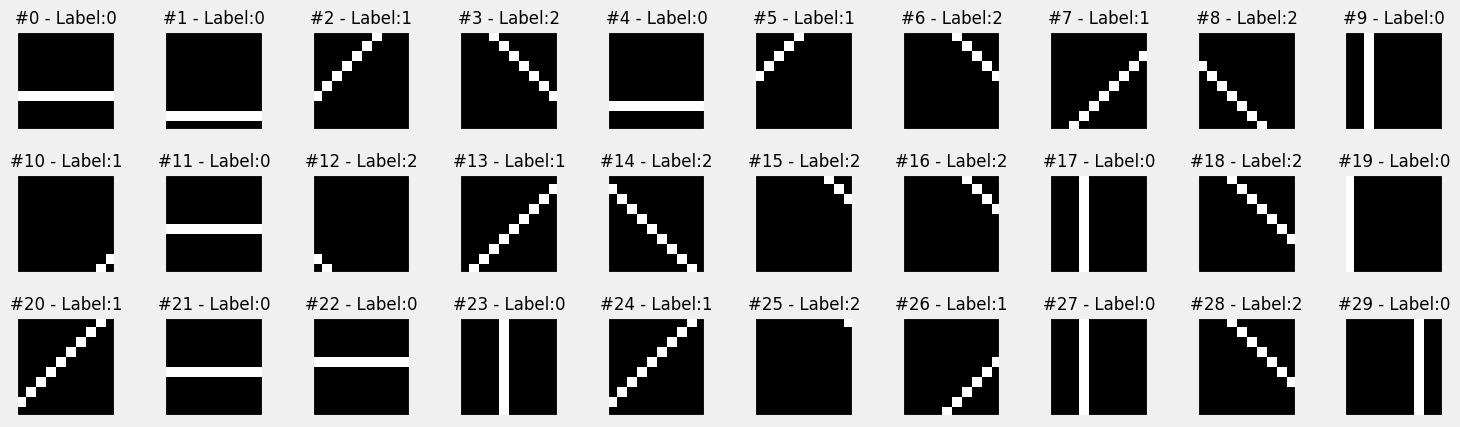

In [10]:
fig = plot_images(images, labels, n_plot=30)

### Preparación de los datos

El paso de preparación de datos sería idéntico al que utilizamos en el capítulo 4 si no fuera por un cambio: esta vez no realizaremos el aumento de los datos, y no lo hacemos porque en nuestro problema particular, voltear una imagen es potencialmente arruinar la etiqueta. 

Si tenemos una imagen que contiene una línea diagonal inclinada hacia la derecha (etiquetada como índice de clase nº 1), y la volteamos, la diagonal acabaría inclinada hacia la izquierda. Pero el aumento de datos no cambia las etiquetas, por lo que el resultado es una imagen con una etiqueta incorrecta (índice de clase nº 1, aunque contendría una línea diagonal inclinada a la izquierda).

Dicho esto, sólo vamos a mantener la escala mín-máx usando la transformada Normalizar . Todo lo demás permanece igual: división conjuntos de datos, muestreador y cargadores de datos.



In [11]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

In [12]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels).long()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# We're not doing any data augmentation now
train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

### Función de pérdida. softmax

```{index} softmax
```

Nuevo problema, y por lo tanto nueva función de  pérdida. Dado que estamos adoptando la clasificación  multiclase ahora, tenemos que utilizar una pérdida diferente. Y, una vez más, todo comienza con nuestro tema "favorito": logits.

La función de pérdida que utilizaremos en el caso de una clasificación múltiple es la denominada *softmax*. La función de pérdida softmax devuelve, para cada clase, la contribución que una clase determinada a la suma de odds ratios. 

$$
\Large
\begin{array}
& z & = \text{logit}(p) & = \text{log odds ratio }(p) & = \text{log}\left(\frac{p}{1-p}\right)
\\
e^z & = e^{\text{logit}(p)} & = \text{odds ratio }(p) & = \left(\frac{p}{1-p}\right)
\end{array}
$$

La función softmax es la siguiente

$$
\Large
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{c=0}^{N_c-1}{e^{z_c}}}
$$

En la ecuación anterior, C representa el número de clases e i corresponde al índice de una clase concreta. En nuestro ejemplo tenemos tres clases, por lo que nuestro modelo debe producir tres logits (z0, z1, z2). Aplicando softmax a estos logits, obtendríamos:

$$
\Large
\text{softmax}(z) = \left[\frac{e^{z_0}}{e^{z_0}+e^{z_1}+e^{z_2}},\frac{e^{z_1}}{e^{z_0}+e^{z_1}+e^{z_2}},\frac{e^{z_2}}{e^{z_0}+e^{z_1}+e^{z_2}}\right]
$$

Sencillo, ¿verdad? Veámoslo ahora en código. Suponiendo que nuestro modelo produce este tensor que contiene tres logits:

In [13]:
logits = torch.tensor([ 1.3863,  0.0000, -0.6931])

Calaculamos la exponencial de los logits para obtener los odds-ratio

In [14]:
odds_ratios = torch.exp(logits)
odds_ratios

tensor([4.0000, 1.0000, 0.5000])

El tensor resultante nos dice que la primera clase tiene muchas más peso que las otras dos, y la segunda tiene mejores probabilidades que la tercera. Así que tomamos estas probabilidades y las sumamos, y luego calculamos la contribución de cada clase a la suma:

In [15]:
softmaxed = odds_ratios / odds_ratios.sum()
softmaxed

tensor([0.7273, 0.1818, 0.0909])

PyTorch proporciona las implementaciones típicas: funcional (F.softmax) y módulo (nn.Softmax):

In [102]:
nn.Softmax(dim=-1)(logits), F.softmax(logits, dim=-1)

(tensor([0.7273, 0.1818, 0.0909]), tensor([0.7273, 0.1818, 0.0909]))

En ambos casos, le pide que indique a qué dimensión debe aplicarse la función softmax. En general, nuestros modelos producirán logits con la forma (número de puntos de datos, número de clases), por lo que la dimensión correcta para aplicar softmax es la última (dim=-1).

### LogSoftmax.

```{index} LogSoftmax
```
La función logsoftmax devuelve, el logaritmo de la  función softmax anterior. Pero, en lugar de calcular  
manualmente el logaritmo, PyTorch proporciona *F.log_softmax y nn.LogSoftmax*.

Estas funciones son más rápidas y también tienen mejores propiedades numéricas. Pero, supongo que tu pregunta principal en este momento es:¿Por qué tengo que tomar el logaritmo de la softmax?. La razón simple y directa es que la función de pérdida espera log-probabilidades como entrada.

### Función de pérdida: Negative Log-Likelihood.

```{index} Negative Log-Likelihood, NLLLoss
```

Como hemos visto, la función *softmax* devuelve probabilidades, mientras que *logsoftmax* devuelve log-probabilidades.
Y esa es la entrada para calcular la función de pérdida Negative Log-Likelihood, o *NLLLoss* para abreviar. Esta función de pérdida es simplemente una extensión de la pérdida de entropía cruzada binaria (ya vista en un tema anterior) para manejar múltiples clases.

Recordemos la fórmula de entropía cruzada binaria. Era la siguiente:

$$
\Large
\texttt{BCE}(y)={-\frac{1}{(N_{\text{pos}}+N_{\text{neg}})}\Bigg[{\sum_{i=1}^{N_{\text{pos}}}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_{\text{neg}}}{\text{log}(1 - \text{P}(y_i=1))}}\Bigg]}
$$

En nuestro ejemplo hay tres clases, es decir, nuestras etiquetas (y) podrían ser cero, uno o dos. Por lo tanto, la función de pérdida, como extensión de la fórmula anterior, tendrá este aspecto:

$$
\Large
\texttt{NLLLoss}(y)={-\frac{1}{(N_0+N_1+N_2)}\Bigg[{\sum_{i=1}^{N_0}{\text{log}(\text{P}(y_i=0))} + \sum_{i=1}^{N_1}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_2}{\text{log}(\text{P}(y_i=2))}}\Bigg]}
$$

Finalmente, para un problema general en el que tengamos C clases, la fórmula de la función de pérdida a emplear sería la siguiente:

$$
\Large \texttt{NLLLoss}(y)={-\frac{1}{(N_0+\cdots+N_{C-1})}\sum_{c=0}^{C-1}{\sum_{i=1}^{N_c}{\text{log}(\text{P}(y_i=c))} }}
$$

Dado que las log-probabilidades se obtienen aplicando *logsoftmax*, esta pérdida no hace mucho más que buscar las entradas
correspondientes a la clase verdadera y sumarlas. Veamos esto en código:


In [103]:
log_probs = F.log_softmax(logits, dim=-1)
log_probs

tensor([-0.3185, -1.7048, -2.3979])

Estas son las probabilidades logarítmicas para cada clase que calculamos utilizando logsoftmax para nuestro único punto de datos. Ahora, supongamos que su etiqueta es dos: ¿cuál es la pérdida correspondiente?

In [104]:
label = torch.tensor([2])
F.nll_loss(log_probs.view(-1, 3), label)

tensor(2.3979)

Como habrás notado, se ha  utilizado la versión funcional de la función de pérdida en el fragmento de código anterior: F.nll_loss. Pero, como hemos hecho con la pérdida de entropía cruzada binaria en el capítulo 3, es más probable que se utilice la versión del módulo: *nn.NLLLoss*.

Al igual que antes, esta función de pérdida es una función de orden superior, y puede tomar tres argumentos opcionales (los otros son obsoletos y puede ignorarlos):

* *reduction*. Toma media como posibles valores: sum, mean o none. El valor por defecto, mean, corresponde a la ecuación  anterior. Como era de esperar, sum devuelve la suma de los errores, en lugar de la media. La última opción  none, corresponde a la forma no reducida, es decir, que devuelve la matriz completa de errores.

* *weight*. Toma un tensor de longitud C, es decir, que contiene tantos pesos como clases.

* *ignore_index*: toma un entero, correspondiente al único índice de clase que debe ignorarse al calcular la función de pérdida. Puede utilizarse para enmascarar una etiqueta concreta que no es relevante para la tarea de clasificación.

Veamos algunos ejemplos rápidos utilizando los argumentos anteriores. En primer lugar, tenemos que generar algunos logits ficticios (aunque seguiremos utilizando tres clases), y las correspondientes log-probabilidades:

In [105]:
torch.manual_seed(11)
dummy_logits = torch.randn((5, 3))
dummy_labels = torch.tensor([0, 0, 1, 2, 1])
dummy_log_probs = F.log_softmax(dummy_logits, dim=-1)

print("Los logits")
print(dummy_logits)
print("----------")
dummy_log_probs

Los logits
tensor([[ 0.7376,  1.9459, -0.6995],
        [-1.3023, -0.5133, -0.2696],
        [ 0.2462,  0.4839,  0.4504],
        [-0.9568,  1.5012, -0.3136],
        [-0.2343, -1.0713,  0.1648]])
----------


tensor([[-1.5229, -0.3146, -2.9600],
        [-1.7934, -1.0044, -0.7607],
        [-1.2513, -1.0136, -1.0471],
        [-2.6799, -0.2219, -2.0367],
        [-1.0728, -1.9098, -0.6737]])

Como las clases observadas son [0,0,1,2,1], al aplicar la fórmula de la función de pérdida, se elegira en la primera fila el valor -1.5229, en la segunda -1.7934, en la tercera -1.0136 (al de la clase 1) y así sucesivamente.

Es decir de una forma manual se puede calcular el valor de la función de pérdida:

In [106]:
relevant_log_probs = torch.tensor([-1.5229, -1.7934, -1.0136, -2.0367, -1.9098])
-relevant_log_probs.mean()

tensor(1.6553)

Ahora vamos a utilizar *nn.NLLLoss* para crear la función de pérdida que nos ofrece PyTorch, y luego utilizar las predicciones y etiquetas para comprobar si tenemos las logprobabilidades relevantes elegidas anteriormente correctas:

In [107]:
loss_fn = nn.NLLLoss()
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.6553)

Como vemos hemos obtenido el mismo valor. ¿Y si queremos equilibrar nuestro conjunto de datos, dando a los puntos  de datos con etiqueta (y=2) el doble de peso que a las otras clases?. Lo haremos de la siguiente forma

In [108]:
loss_fn = nn.NLLLoss(weight=torch.tensor([1., 1., 2.]))
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.7188)

¿Y si simplemente queremos ignorar los puntos de datos con la etiqueta (y=2)?

In [109]:
loss_fn = nn.NLLLoss(ignore_index=2)
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.5599)

Y, una vez más, hay otra función de pérdida disponible para clasificación multiclase. Y, una vez más, es muy importante saber cuándo usar una u otra, para no acabar con una combinación inconsistente de modelo y función de pérdida.

### Función de pérdida: Cross-Entropy 

```{index} Cross-Entropy 
```

La función de pérdida del apartado anterior tomaba como argumento las probabilidades logarítmicas (junto con las etiquetas, obviamente). Sin embargo esta función tarabaja con los Logits. Es la versión multiclase de *nn.BCEConLogitsPérdida*, ya vista en un tema anterior.

En términos prácticos, esto significa que **NO** debe añadir un *logsoftmax* como la última capa de su modelo cuando utilice esta función de pérdida. Esta función de pérdida combina la capa logsoftmax y la anterior pérdida de log-verosimilitud negativa en una sola.

Por lo tanto en la clasificación multiclase se tienen las dos alternativas siguientes:

1.- Se tiene *nn.LogSoftmax* como última capa, lo que significa que su modelo está produciendo logprobabilidades,
se debe combinar con la función nn.NLLLoss

2.- No se coloca logsoftmax en la última capa, lo que significa que su modelo está produciendo logits, y por lo tanto se debe combinar con la función nn.CrossEntropyLoss.

La función de pérdida *nn.CrossEntropyLoss* toma los mismos argumentos que nn.NLLLoss:

* *reduction*. Toma media como posibles valores: sum, mean o none. El valor por defecto, mean, corresponde a la ecuación  anterior. Como era de esperar, sum devuelve la suma de los errores, en lugar de la media. La última opción  none, corresponde a la forma no reducida, es decir, que devuelve la matriz completa de errores.

* *weight*. Toma un tensor de longitud C, es decir, que contiene tantos pesos como clases.

* *ignore_index*: toma un entero, correspondiente al único índice de clase que debe ignorarse al calcular la función de pérdida. Puede utilizarse para enmascarar una etiqueta concreta que no es relevante para la tarea de clasificación.

Veamos un ejemplo de su uso utilizando los datos que se ha generado para la función nn.NLLLoss

In [110]:
torch.manual_seed(11)
dummy_logits = torch.randn((5, 3))
dummy_labels = torch.tensor([0, 0, 1, 2, 1])
loss_fn = nn.CrossEntropyLoss()
loss_fn(dummy_logits, dummy_labels)

tensor(1.6553)

Como es de esperar obtenemos el mismo resultado que con nn.NLLLoss.

Para intentar y aclarar todos estos procesos, a continuación se muestra una tabla que pretende resumir y aclarar el procedimiento a utilizar en cada caso.

![cuadro utilidad](figuras/tabla1.PNG)

## Configuración del modelo

Vamos a construir nuestra primera red neuronal convolucional de verdad. Podemos utilizar el típico bloque convolucional: capa convolucional, función de activación, capa de agrupamiento o pooling. Nuestras imágenes son bastante pequeñas, así que
sólo necesitamos uno de ellos.

Todavía tenemos que decidir cuántos canales de nuestra capa convolucional va a producir. En general, el número de canales aumenta con cada bloque convolucional. Por simplicidad (y posterior visualización), vamos a mantener un solo canal.

También tenemos que decidir el tamaño del núcleo (el campo receptivo o las regiones grises en las figuras al principio de este capítulo).. Sigamos con un tamaño de núcleo de tres, lo que reducirá el tamaño de la imagen en dos píxeles en cada dimensión (aquí no utilizamos relleno).

El código sería el siguiente

In [111]:
torch.manual_seed(13)
model_cnn1 = nn.Sequential()

# Featurizer
# Block 1: 1@10x10 -> n_channels@8x8 -> n_channels@4x4
n_channels = 1
model_cnn1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=3))
model_cnn1.add_module('relu1', nn.ReLU())
model_cnn1.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# Flattening: n_channels * 4 * 4
model_cnn1.add_module('flatten', nn.Flatten())

Se ha puesto el número de canales como una variable, con la finalidad de que se puedan probar diferentes valores si así se desea.

Veamos lo que ocurre con una imagen de entrada (monocanal, 10x10 píxeles - 1@10x10):

* La imagen se convoluciona con el núcleo y la imagen resultante tiene un canal, y su tamaño es de 8x8 píxeles (1@8x8).

* Se aplica una función de activación ReLU a la imagen resultante.

* La imagen "activada" (es decir salida de la función de activación) se somete a una operación de max-pooling con un
tamaño de núcleo de dos, por lo que se divide en 16 trozos de tamaño dos por dos, lo que da como resultado una imagen con un canal, pero de 4x4 píxeles de tamaño (1@4x4)

* estos 16 valores pueden considerarse features, y se aplanan en un tensor de 16 elementos

La siguiente parte de nuestro modelo, el clasificador, utiliza estas características para alimentar lo que sería una simple red neuronal con una sola capa oculta si se considerara por sí sola:

In [112]:
# Classification
# Hidden Layer
model_cnn1.add_module('fc1', nn.Linear(in_features=n_channels*4*4, out_features=10))
model_cnn1.add_module('relu2', nn.ReLU())
# Output Layer
model_cnn1.add_module('fc2', nn.Linear(in_features=10, out_features=3))

Hay una capa oculta que toma las 16 características como entradas y las mapea en un espacio de 10 dimensiones que va a ser
"activado" por el ReLU.

A continuación, la capa de salida produce tres combinaciones lineales distintas de diez valores de activación.Cada combinación corresponde a una clase diferente. La figura siguiente, representa la la segunda mitad del modelo:

![Segunda parte del modelo](figuras/ModeloLineal.PNG)



Debemos tener presente que al producir nuestro modelo como resultado final logits entonces debemos utilizar la función de pérdida  nn.CrossEntropyLoss.  

In [113]:
lr=0.1
# definición de la función de pérdida
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')

# Implementamos el optimizador
optimizer_cnn1 = optim.SGD(model_cnn1.parameters(), lr=lr)

Con todo esto ya podemos entrenar el modelo

In [114]:
sbs_cnn1 = StepByStep(model_cnn1, multi_loss_fn, optimizer_cnn1)
sbs_cnn1.set_loaders(train_loader, val_loader)

Lo entrenamos con 20 epochs y visualizamos las funciones de pérdida

In [115]:
sbs_cnn1.train(20)

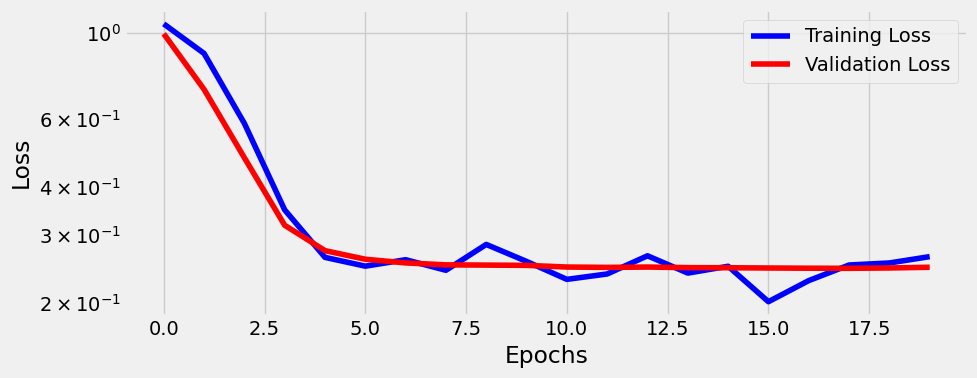

In [116]:
fig = sbs_cnn1.plot_losses()

## Visualizando los filtros

En el capítulo 4 hablamos brevemente de la visualización de pesos como píxeles. Vamos a profundizar en la visualización de filtros (pesos), así como las imágenes transformadas producidas por cada una de nuestras capas de nuestro modelo. 

En primer lugar añadimos un nuevo método a nuestra clase StepByStep.

In [117]:
@staticmethod
def _visualize_tensors(axs, x, y=None, yhat=None, 
                       layer_name='', title=None):
    # The number of images is the number of subplots in a row
    n_images = len(axs)
    # Gets max and min values for scaling the grayscale
    minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
    # For each image
    for j, image in enumerate(x[:n_images]):
        ax = axs[j]
        # Sets title, labels, and removes ticks
        if title is not None:
            ax.set_title(f'{title} #{j}', fontsize=12)
        shp = np.atleast_2d(image).shape
        ax.set_ylabel(
            f'{layer_name}\n{shp[0]}x{shp[1]}',
            rotation=0, labelpad=40
        )
        xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
        xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
        xlabel = f'{xlabel1}{xlabel2}'
        if len(xlabel):
            ax.set_xlabel(xlabel, fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

        # Plots weight as an image
        ax.imshow(
            np.atleast_2d(image.squeeze()),
            cmap='gray', 
            vmin=minv, 
            vmax=maxv
        )
    return

setattr(StepByStep, '_visualize_tensors', _visualize_tensors)

La mayor parte del cuerpo de la función es el manejo de los títulos, etiquetas, y los ticks de los ejes
antes de usar imshow para trazar la imagen, así que no es tan interesante.Explicamos sus argumentos:

* *axs*: una matriz de subplots, correspondiente a una fila de subplots tal y como lo devuelve el subplot de Matplotlib.

* *x*: una matriz de tio Numpy array  que contenga al menos tantas imágenes/filtros como subplots en *axs*.

* *y*: argumento opcional, es un numpy array  que contiene al menos tantas etiquetas como subplots en *axs*.

* *yhat*. argumento opcional, es un numpy array que contiene al menos tantas etiquetas predichas como subplots en *axs*.

* *layer_name*.: etiqueta para la fila de subplots.

* *title*: Prefijo del título para cada subplot

Observemos que el método anterior tiene el decorador *@staticmethod*, lo que indica que <a href="https://ellibrodepython.com/metodos-estaticos-clase-python"  target="_blank"> es un método estático </a>, y como tal no tiene un argumento self.  El funcionamiento interno de la función debe ser independiente de la instancia de la clase a la que pertenece. El método estático puede ejecutarse desde la propia clase en lugar de desde una de sus instancias. Esto lo vemos en el siguiente ejemplo

In [118]:
class Cat(object):
    def __init__(self, name):
        self.name = name

    @staticmethod
    def meow():
        print('Meow')

In [119]:
Cat.meow()

Meow


## Visualizando filtros.

Podríamos aplicar el mismo principio a los pesos del filtro aprendido por nuestra capa convolucional. Podemos acceder a los pesos de cualquier capa utilizando la notación de puntos:

In [120]:
weights_filter = model_cnn1.conv1.weight.data.cpu().numpy()
weights_filter.shape

(1, 1, 3, 3)

Las dimensiones (shape) de los pesos (que representan los filtros) de una capa bidimensional viene dada por (canales_salida, in_channels, kernel_size, kernel_size). En nuestro caso, el tamaño del kernel es tres, y tenemos un único canal, tanto de entrada como de salida, por lo que la shape de los pesos es (1, 1, 3, 3).

Y aquí es cuando el método estático que desarrollamos en la sección anterior entra en escena: podemos recorrer en bucle los filtros (canales de de salida) que el modelo aprendió para convolucionar cada uno de los de entrada.



In [121]:
def visualize_filters(self, layer_name, **kwargs):
    try:
        # Gets the layer object from the model
        layer = self.model
        for name in layer_name.split('.'):
            layer = getattr(layer, name)
        # We are only looking at filters for 2D convolutions
        if isinstance(layer, nn.Conv2d):
            # Takes the weight information
            weights = layer.weight.data.cpu().numpy()
            # weights -> (channels_out (filter), channels_in, H, W)
            n_filters, n_channels, _, _ = weights.shape

            # Builds a figure
            size = (2 * n_channels + 2, 2 * n_filters)
            fig, axes = plt.subplots(n_filters, n_channels, 
                                     figsize=size)
            axes = np.atleast_2d(axes)
            axes = axes.reshape(n_filters, n_channels)
            # For each channel_out (filter)
            for i in range(n_filters):    
                StepByStep._visualize_tensors(
                    axes[i, :],
                    weights[i],
                    layer_name=f'Filter #{i}', 
                    title='Channel'
                )
                    
            for ax in axes.flat:
                ax.label_outer()

            fig.tight_layout()
            return fig
    except AttributeError:
        return
    
setattr(StepByStep, 'visualize_filters', visualize_filters)

Bien con todo lo anterior, podremos ver cómo queda el filtro:

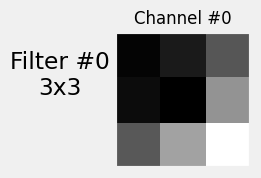

In [122]:
fig = sbs_cnn1.visualize_filters('conv1', cmap='gray')

Sólo con mirar este filtro, no es fácil comprender lo que está logrando efectivamente. Para comprender realmente el efecto que tiene este filtro en cada imagen, necesitamos visualizar los valores intermedios producidos por nuestro modelo, es decir, la salida de todas y cada una de las capas. 

Para poder visualizar la salida de cada capa necesitamos poner en escena el concepto de **hooks**.

## Hooks

```{index} Hooks, register_forward_hook
```

Un *Hooks* (o gancho ) es simplemente una forma de forzar a un modelo a ejecutar una función ya sea después de su paso hacia adelante (step forward) o hacia atrás (step backward). Por lo tanto, existen ganchos hacia adelante y hacia atrás. Estamos utilizando sólo hacia adelante pero la idea es la misma para ambos.

Para ver y entender cómo se crean estas funciones, vamos a montar a continuación una que sirva de ejemplo. Será una función de tipo hook para un step forward.

In [123]:
dummy_model = nn.Linear(1, 1)

dummy_list = []

def dummy_hook(layer, inputs, outputs):
    dummy_list.append((layer, inputs, outputs))

Las funciones de tipo hook (forward) tienen tres argumentos:

* Un modelo (layer en la función anterior).

* Un tensor representando los inputs que toma el modelo o capa.

* Un tensor representando los outputs generados por el modelo o capa.

Por lo tanto, cualquier función que tome tres argumentos, independientemente de sus nombres, puede funcionar como gancho o hook. En nuestro caso (y en muchos otros casos también), nos gustaría tener la información que pasa por la función hook. Esa es la misión de la variable *dummy_list* en el fragmento anterior. Nuestra función dummy_hook es de lo más básica: simplemente añade una tupla de sus tres argumentos a la variable dummy_list definida fuera de la función hook.

Entonces definiendo la función hook de ese modo, ¿cómo asociarla o engancharla al modelo?. Pues bien, para hacer esto existe el método <a href="https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook" target="_blank"> register_forward_hook </a>, la cual toma como argumento una función de tipo hook y devuelve un **handle**,para que podamos realizar un seguimiento de los hooks conectados a nuestro modelo.

In [124]:
dummy_handle = dummy_model.register_forward_hook(dummy_hook)
dummy_handle

Pongamos esto en funcionamiento

In [125]:
# generamos un tensor
dummy_x = torch.tensor([0.3])
# damos un paso hacia adelante
dummy_model.forward(dummy_x)

tensor([-0.8366], grad_fn=<AddBackward0>)

Esto debería añadir una nueva tupla a la lista ficticia, que contenga una capa lineal, un tensor de entrada (0,3) y un tensor de salida (-0,7514).Por cierto, al ejecutar varias veces este código los valores obtenidos van a ser diferentes a los aquí obtenidos, ya que no nos molestamos en usar una semilla aquí. Veamos pues el contenido de la lista dummy

In [126]:
dummy_list

[]

Vemos que nuestra lista está vacía, porque debemos recordar y destacar lo siguiente:

:::{note}
¡NO se debe llamar al método forward(x)!. Se debe llamar al modelo completo con el comando *model(x)* para realizar un forward pass.

De lo contrario, los hooks no funcionarán.
:::

Hagamos pues esto:

In [127]:
dummy_model(dummy_x)

tensor([-0.8366], grad_fn=<AddBackward0>)

In [128]:
dummy_list

[(Linear(in_features=1, out_features=1, bias=True),
  (tensor([0.3000]),),
  tensor([-0.8366], grad_fn=<AddBackward0>))]

¡Ahora sí! Aquí está la tupla que esperábamos. Si vuelves a llamar al modelo una vez más, añadirá otra tupla a la lista,
y así sucesivamente. Este gancho va a ser enganchado a nuestro modelo hasta que se elimine explícitamente. Para eliminar un gancho, basta con llamar a su método remove:

In [129]:
dummy_handle.remove()

Y el gancho se va. Pero no perdimos la información ya que nuestra variable, *dummy_list* estaba definida fuera de la función hook.

Fíjate en el primer elemento de la tupla: es una instancia de un modelo (o capa). Incluso si usamos un modelo secuencial y nombramos las capas, los nombres no llegarán a la función hook. Así que tenemos que  hacer la asociación nosotros mismos.

```{index} named_modules
```

Volvamos ahora a nuestro modelo real con el que estábamos trabajando. Podemos obtener una lista de todos sus
módulos con nombre utilizando el método apropiado:<a href="https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.named_modules" target="_blank"> named_modules </a>:

In [130]:
modules = list(sbs_cnn1.model.named_modules())
modules

[('',
  Sequential(
    (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=16, out_features=10, bias=True)
    (relu2): ReLU()
    (fc2): Linear(in_features=10, out_features=3, bias=True)
  )),
 ('conv1', Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))),
 ('relu1', ReLU()),
 ('maxp1',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('flatten', Flatten(start_dim=1, end_dim=-1)),
 ('fc1', Linear(in_features=16, out_features=10, bias=True)),
 ('relu2', ReLU()),
 ('fc2', Linear(in_features=10, out_features=3, bias=True))]

El primer módulo, sin nombre, es el modelo completo. Los otros módulos son sus capas. Y esas capas son una de las entradas de la función hook. Por lo tanto, tenemos que ser capaces de buscar el nombre, dada la instancia de la capa correspondiente. Veamos la forma de hacerlo (mediante un diccinario comprehension​ de Python):


In [131]:
layer_names = {layer: name for name, layer in modules[1:]}
layer_names

{Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1)): 'conv1',
 ReLU(): 'relu1',
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): 'maxp1',
 Flatten(start_dim=1, end_dim=-1): 'flatten',
 Linear(in_features=16, out_features=10, bias=True): 'fc1',
 ReLU(): 'relu2',
 Linear(in_features=10, out_features=3, bias=True): 'fc2'}

Un diccionario es perfecto para eso: la función hook tomará la capa y buscará su nombre en el diccionario. Entonces con todo esto, vamos a generar nuestra función hook

In [132]:
visualization = {}

def hook_fn(layer, inputs, outputs):
    name = layer_names[layer]
    visualization[name] = outputs.detach().cpu().numpy()

En realidad es bastante sencillo: busca el nombre de la capa y lo utiliza como clave de un diccionario definido fuera de la función hook, que almacenará las salidas producidas por la capa enganchada. Los inputs son ignorados en esta función.

Podemos hacer una lista de las capas de las que nos gustaría obtener las salidas, hacer un bucle en modules y para cada nombre y capa del mismo pasarlo a un diccionario denominado handles:


In [133]:
layers_to_hook = ['conv1', 'relu1', 'maxp1', 'flatten', 'fc1', 'relu2', 'fc2']

handles = {}

for name, layer in modules:
    if name in layers_to_hook:
        handles[name] = layer.register_forward_hook(hook_fn)

Ya está todo en su sitio. Lo único que queda por hacer es llamar al modelo, de modo que se active un pase hacia adelante,
y las salidas de todas estas capas se almacenan en el diccionario de visualización.

Obtengamos un mini lote del cargador de validación y utilicemos el método *predict* de nuestra clase StepByStep (que llamará al modelo modelo entrenado):

In [137]:
images_batch, labels_batch = iter(val_loader).next()
#images_batch, labels_batch = enumerate(enumerate(val_loader))
#logits = sbs_cnn1.predict(images_batch)

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

In [135]:
enumerate(val_loader)

In [139]:
type(val_loader)

torch.utils.data.dataloader.DataLoader

In [138]:
val_loader

In [140]:
type(iter(val_loader))

torch.utils.data.dataloader._SingleProcessDataLoaderIter

In [142]:
a = iter(val_loader)

<!-- Lo dejo en página 539. Pero el error que me da debe ser por la versión de Pytorch que tengo. -->